In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

#packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# reading data from csv and creating a dataframe
df = pd.read_csv('Google-Playstore.csv')

# dataframe dimensions
print(f"This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataframe has 603047 rows and 23 columns.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603047 entries, 0 to 603046
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   App Name           603046 non-null  object 
 1   App Id             603047 non-null  object 
 2   Category           603047 non-null  object 
 3   Rating             599287 non-null  float64
 4   Rating Count       599287 non-null  float64
 5   Installs           602875 non-null  object 
 6   Minimum Installs   602875 non-null  float64
 7   Maximum Installs   603047 non-null  int64  
 8   Free               603047 non-null  bool   
 9   Price              603047 non-null  float64
 10  Currency           602866 non-null  object 
 11  Size               603047 non-null  object 
 12  Minimum Android    602556 non-null  object 
 13  Developer Id       603045 non-null  object 
 14  Developer Website  423783 non-null  object 
 15  Developer Email    603010 non-null  object 
 16  Re

In [4]:
#Drop unnecessary variables: Deveopler Website, Developer Id, Developer Email, Privacy Policy
df = df.drop(['Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy'], axis = 1)

In [5]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum()\
                     / df.shape[0]\
                     * 100),
            columns=['Column', 'Has Missing Values?', '% Missing Values'])\
    .sort_values('% Missing Values', ascending=False)

,Column,Has Missing Values?,% Missing Values
13,Released,True,5.352485
3,Rating,True,0.623500
4,Rating Count,True,0.623500
12,Minimum Android,True,0.081420
10,Currency,True,0.030014
5,Installs,True,0.028522
6,Minimum Installs,True,0.028522
0,App Name,True,0.000166
17,In App Purchases,False,0.000000
16,Ad Supported,False,0.000000


In [6]:
#CATEGORY 1
lifestyle=['Beauty','Dating','Food&Drink','House&Home','Lifestyle','Music','Music&Audio',
           'Personalization','Photography','Parenting','Shopping','Social']
#CATEGORY 2
education=['Art&Design','Books&Reference','Education','Educational','Libraries&Demo']
#CATEGORY 3
health=['Health&Fitness','Medical']
#CATEGORY 4
travel=['Auto&Vehicles','Maps&Navigation','Travel&Local']
#CATEGORY 5
communication=['Communication']
#CATEGORY 6
news=['News&Magazines']
#CATEGORY 7
tools=['Tools','VideoPlayers&Editors','Word','Productivity']
#CATEGORY 8
weather=['Weather']
#CATEGORY 9
business=['Business','Finance']
#CATEGORY 10
entertainment = ['Entertainment','Action','Adventure','Arcade','Board','Comics','Card','Casino','Casual','Events',
                 'Puzzle','Racing','Role Playing','Simulation','Sports','Strategy','Trivia']

In [7]:
df.loc[df['Category'].isin(lifestyle), 'c_lifestyle'] = np.int64(1)
df['c_lifestyle'] = df['c_lifestyle'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(education), 'c_education'] = np.int64(1)
df['c_education'] = df['c_education'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(health), 'c_health'] = np.int64(1)
df['c_health'] = df['c_health'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(travel), 'c_travel'] = np.int64(1)
df['c_travel'] = df['c_travel'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(communication), 'c_communication'] = np.int64(1)
df['c_communication'] = df['c_communication'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(news), 'c_news'] = np.int64(1)
df['c_news'] = df['c_news'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(tools), 'c_tools'] = np.int64(1)
df['c_tools'] = df['c_tools'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(weather), 'c_weather'] = np.int64(1)
df['c_weather'] = df['c_weather'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(business), 'c_business'] = np.int64(1)
df['c_business'] = df['c_business'].replace(np.nan, np.int64(0))

df.loc[df['Category'].isin(entertainment), 'c_entertainment'] = np.int64(1)
df['c_entertainment'] = df['c_entertainment'].replace(np.nan, np.int64(0))

In [8]:
df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,c_lifestyle,c_education,c_health,c_travel,c_communication,c_news,c_tools,c_weather,c_business,c_entertainment
0,foodpanda - Local Food & Grocery Delivery,com.global.foodpanda.android,Food & Drink,4.4,1258493.0,"10,000,000+",10000000.0,48828081,True,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Tripadvisor Hotel, Flight & Restaurant Bookings",com.tripadvisor.tripadvisor,Travel & Local,4.4,1360172.0,"100,000,000+",100000000.0,371284181,True,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Safeway Delivery & Pick Up,com.safeway.shop,Shopping,4.2,5532.0,"500,000+",500000.0,816102,True,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,My CookBook Ad-Free,fr.cookbookpro,Food & Drink,4.7,2531.0,"10,000+",10000.0,16171,False,5.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Talabat: Food & Grocery Delivery,com.talabat,Food & Drink,4.4,197649.0,"5,000,000+",5000000.0,9218590,True,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print(df.c_lifestyle.value_counts())
print(df.c_health.value_counts())
print(df.c_travel.value_counts())
print(df.c_communication.value_counts())
print(df.c_news.value_counts())
print(df.c_tools.value_counts())
print(df.c_weather.value_counts())
print(df.c_business.value_counts())
print(df.c_entertainment.value_counts())

0.0    500232
1.0    102815
Name: c_lifestyle, dtype: int64
0.0    594682
1.0      8365
Name: c_health, dtype: int64
0.0    603047
Name: c_travel, dtype: int64
0.0    591278
1.0     11769
Name: c_communication, dtype: int64
0.0    603047
Name: c_news, dtype: int64
0.0    541275
1.0     61772
Name: c_tools, dtype: int64
0.0    600492
1.0      2555
Name: c_weather, dtype: int64
0.0    556005
1.0     47042
Name: c_business, dtype: int64
0.0    492704
1.0    110343
Name: c_entertainment, dtype: int64


In [10]:
df.c_education.value_counts()

0.0    520983
1.0     82064
Name: c_education, dtype: int64

## Size variable

In [11]:
#Remove Varies with Device from Size
df = df[df['Size'] != 'Varies with device']

In [12]:
kb_index = df.Size[df.Size.str.contains('k')].index
mb_index = df.Size[(df.Size.str.contains('M'))].index

In [13]:
#Remove M,k,, from the size variable
#df['Size'] = df['Size'].str.replace('.','')
df['Size'] = df['Size'].str.replace(',','')
df.Size = df.Size.str.replace('M','')
df.Size = df.Size.str.replace('k','')

In [14]:
df.Size = pd.to_numeric(df.Size,errors='coerce')
df.Size.loc[mb_index] = df.Size.loc[mb_index] * 1000

/Users/nidhi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
df.Size.value_counts()

11000.0     16960
12000.0     14280
13000.0     12196
14000.0     11249
16000.0     10784
            ...  
198000.0        1
347000.0        1
318000.0        1
225000.0        1
233000.0        1
Name: Size, Length: 1386, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577106 entries, 0 to 603046
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   App Name          577105 non-null  object 
 1   App Id            577106 non-null  object 
 2   Category          577106 non-null  object 
 3   Rating            576880 non-null  float64
 4   Rating Count      576880 non-null  float64
 5   Installs          577049 non-null  object 
 6   Minimum Installs  577049 non-null  float64
 7   Maximum Installs  577106 non-null  int64  
 8   Free              577106 non-null  bool   
 9   Price             577106 non-null  float64
 10  Currency          577041 non-null  object 
 11  Size              577106 non-null  float64
 12  Minimum Android   576632 non-null  object 
 13  Released          549530 non-null  object 
 14  Last Updated      577106 non-null  object 
 15  Content Rating    577106 non-null  object 
 16  Ad Supported      57

In [17]:
df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,c_lifestyle,c_education,c_health,c_travel,c_communication,c_news,c_tools,c_weather,c_business,c_entertainment
0,foodpanda - Local Food & Grocery Delivery,com.global.foodpanda.android,Food & Drink,4.4,1258493.0,"10,000,000+",10000000.0,48828081,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Safeway Delivery & Pick Up,com.safeway.shop,Shopping,4.2,5532.0,"500,000+",500000.0,816102,True,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,DoorDash - Food Delivery,com.dd.doordash,Food & Drink,4.5,784802.0,"10,000,000+",10000000.0,24426156,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Peapod Delivery,com.peapod.app.mobile.droid,Shopping,2.8,2487.0,"500,000+",500000.0,571969,True,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FreshDirect,com.freshdirect.android,Shopping,2.1,893.0,"100,000+",100000.0,184884,True,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Installs variable

In [18]:
df['Installs'] = df['Installs'].str.replace('+','')
df['Installs'] = df['Installs'].str.replace(',','')
df.Installs = pd.to_numeric(df.Installs,errors='coerce')

In [19]:
def cat(x):
    if x <1000:
        return "VeryLow"
    elif (x>=1000 and x<10000):
        return "Low"
    elif (x>=10000 and x<100000):
        return "Medium"
    elif (x>=100000 and x<1000000):
        return "High"
    else:
        return "VeryHigh"

for col in df.columns:
    df['InstallCategory'] = df['Installs'].apply(lambda x: cat(x))

In [20]:
df['InstallCategory'].value_counts()

VeryLow     188763
Low         152087
Medium      140669
High         69467
VeryHigh     26120
Name: InstallCategory, dtype: int64

In [21]:
df = pd.get_dummies(df, columns=['InstallCategory'])
df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,c_news,c_tools,c_weather,c_business,c_entertainment,InstallCategory_High,InstallCategory_Low,InstallCategory_Medium,InstallCategory_VeryHigh,InstallCategory_VeryLow
0,foodpanda - Local Food & Grocery Delivery,com.global.foodpanda.android,Food & Drink,4.4,1258493.0,10000000.0,10000000.0,48828081,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
2,Safeway Delivery & Pick Up,com.safeway.shop,Shopping,4.2,5532.0,500000.0,500000.0,816102,True,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
5,DoorDash - Food Delivery,com.dd.doordash,Food & Drink,4.5,784802.0,10000000.0,10000000.0,24426156,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
6,Peapod Delivery,com.peapod.app.mobile.droid,Shopping,2.8,2487.0,500000.0,500000.0,571969,True,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
8,FreshDirect,com.freshdirect.android,Shopping,2.1,893.0,100000.0,100000.0,184884,True,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


## Currency Variable

In [22]:
df.Currency.value_counts()

USD    576945
XXX        60
EUR        13
GBP         5
INR         3
UAH         3
SGD         2
TRY         1
VND         1
IDR         1
JPY         1
CAD         1
RON         1
RUB         1
KRW         1
HKD         1
BRL         1
Name: Currency, dtype: int64

In [23]:
# remove apps other than US
df = df[df['Currency'] == 'USD']

## Release Variable

In [24]:
df.Released=pd.to_datetime(df.Released)

In [25]:
df['ReleaseMonth']= df['Released'].dt.month

In [26]:
df = df.dropna(subset=['ReleaseMonth'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549436 entries, 0 to 603046
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   App Name                  549435 non-null  object        
 1   App Id                    549436 non-null  object        
 2   Category                  549436 non-null  object        
 3   Rating                    549391 non-null  float64       
 4   Rating Count              549391 non-null  float64       
 5   Installs                  549436 non-null  float64       
 6   Minimum Installs          549436 non-null  float64       
 7   Maximum Installs          549436 non-null  int64         
 8   Free                      549436 non-null  bool          
 9   Price                     549436 non-null  float64       
 10  Currency                  549436 non-null  object        
 11  Size                      549436 non-null  float64       
 12  Mi

In [28]:
df['Rating']=df['Rating'].fillna(df['Rating'].mean())

In [39]:
predictors = ['Installs','Free','Price','Size','c_lifestyle','c_education','c_health','c_travel','c_communication'
              ,'c_news','c_tools','c_weather','c_business','c_entertainment','InstallCategory_High','InstallCategory_Low','InstallCategory_Medium'
              ,'InstallCategory_VeryHigh','InstallCategory_VeryLow','ReleaseMonth']
target = ['Rating']

predictors2 = ['Free','Size','c_lifestyle','c_education','c_health','c_travel','c_communication'
              ,'c_news','c_tools','c_business','c_entertainment','InstallCategory_High','InstallCategory_Low','InstallCategory_Medium'
              ,'InstallCategory_VeryHigh','InstallCategory_VeryLow','ReleaseMonth']

In [30]:
df['c_lifestyle'] = pd.Categorical(df.c_lifestyle)
df['c_education'] = pd.Categorical(df.c_education)
df['c_health'] = pd.Categorical(df.c_health)
df['c_travel'] = pd.Categorical(df.c_travel)
df['c_communication'] = pd.Categorical(df.c_communication)
df['c_news'] = pd.Categorical(df.c_news)
df['c_tools'] = pd.Categorical(df.c_tools)
df['c_weather'] = pd.Categorical(df.c_weather)
df['c_business'] = pd.Categorical(df.c_business)
df['c_entertainment'] = pd.Categorical(df.c_entertainment)
df['InstallCategory_High'] = pd.Categorical(df.InstallCategory_High)
df['InstallCategory_Low'] = pd.Categorical(df.InstallCategory_Low)
df['InstallCategory_Medium'] = pd.Categorical(df.InstallCategory_Medium)
df['InstallCategory_VeryHigh'] = pd.Categorical(df.InstallCategory_VeryHigh)
df['InstallCategory_VeryLow'] = pd.Categorical(df.InstallCategory_VeryLow)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549436 entries, 0 to 603046
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   App Name                  549435 non-null  object        
 1   App Id                    549436 non-null  object        
 2   Category                  549436 non-null  object        
 3   Rating                    549436 non-null  float64       
 4   Rating Count              549391 non-null  float64       
 5   Installs                  549436 non-null  float64       
 6   Minimum Installs          549436 non-null  float64       
 7   Maximum Installs          549436 non-null  int64         
 8   Free                      549436 non-null  bool          
 9   Price                     549436 non-null  float64       
 10  Currency                  549436 non-null  object        
 11  Size                      549436 non-null  float64       
 12  Mi

In [42]:
from regressors import stats
import statsmodels.api as sm

X = df[predictors2]
y = df[target]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 3.881e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:17:31   Log-Likelihood:            -9.4732e+05
No. Observations:              549436   AIC:                         1.895e+06
Df Residuals:                  549421   BIC:                         1.895e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  

# the independent variables set 
X = df[predictors2]
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

/Users/nidhi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     feature       VIF
0                       Free  1.038122
1                       Size  1.085448
2                c_lifestyle  1.310518
3                c_education  1.258047
4                   c_health  1.031320
5                   c_travel       NaN
6            c_communication  1.043297
7                     c_news       NaN
8                    c_tools  1.208885
9                 c_business  1.152160
10           c_entertainment  1.370282
11      InstallCategory_High  4.614312
12       InstallCategory_Low  8.027974
13    InstallCategory_Medium  7.925572
14  InstallCategory_VeryHigh  2.510219
15   InstallCategory_VeryLow  8.699468
16              ReleaseMonth  1.000770


In [73]:
predictors3 = ['Free','Size','c_lifestyle','c_education','c_health','c_travel','c_communication'
              ,'c_news','c_tools','c_business','c_entertainment','InstallCategory_High','InstallCategory_Low','InstallCategory_Medium'
              ,'InstallCategory_VeryHigh','InstallCategory_VeryLow','ReleaseMonth']

In [74]:
from regressors import stats
import statsmodels.api as sm

X = df[predictors3]
y = df[target]
#X = sm.add_constant(X) # adding a constant

model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 3.881e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:30:06   Log-Likelihood:            -9.4732e+05
No. Observations:              549436   AIC:                         1.895e+06
Df Residuals:                  549421   BIC:                         1.895e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Free                    

In [75]:
X.corr(method ='pearson') 

,Free,Size,ReleaseMonth
Free,1.000000,-0.022693,-0.000627
Size,-0.022693,1.000000,0.002621
ReleaseMonth,-0.000627,0.002621,1.000000


## LASSO & RIDGE

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge


#Scaling parameters

scaler = StandardScaler()
df[['Free','Size','ReleaseMonth']] = scaler.fit_transform(df[['Free','Size','ReleaseMonth']])
                            

In [79]:
# Running LASSO with alpha. = 0.5
X = df[predictors3]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5)

In [80]:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)

Lasso Regression: R^2 score on training set 16.830519453749215
Lasso Regression: R^2 score on test set 16.802357465294925


In [81]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)


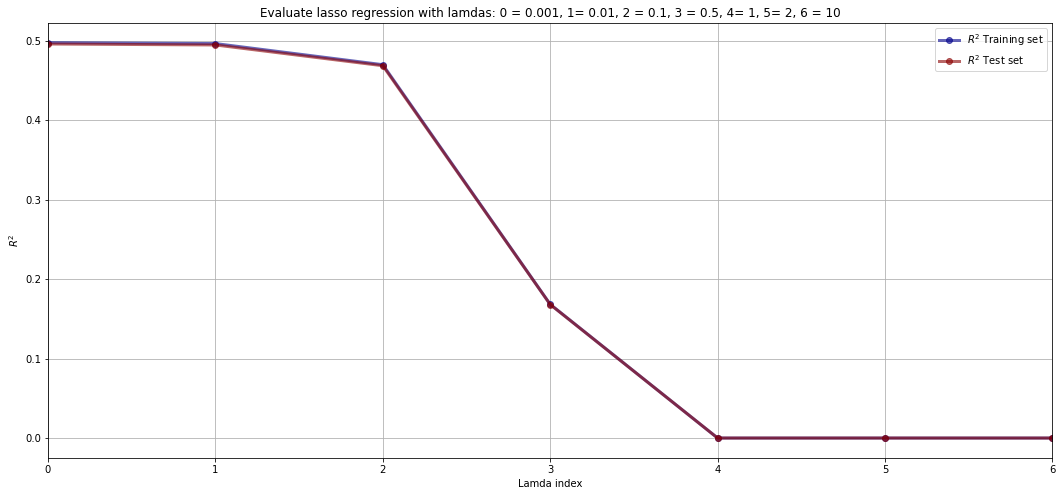

In [82]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [90]:
X = df[predictors3]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)


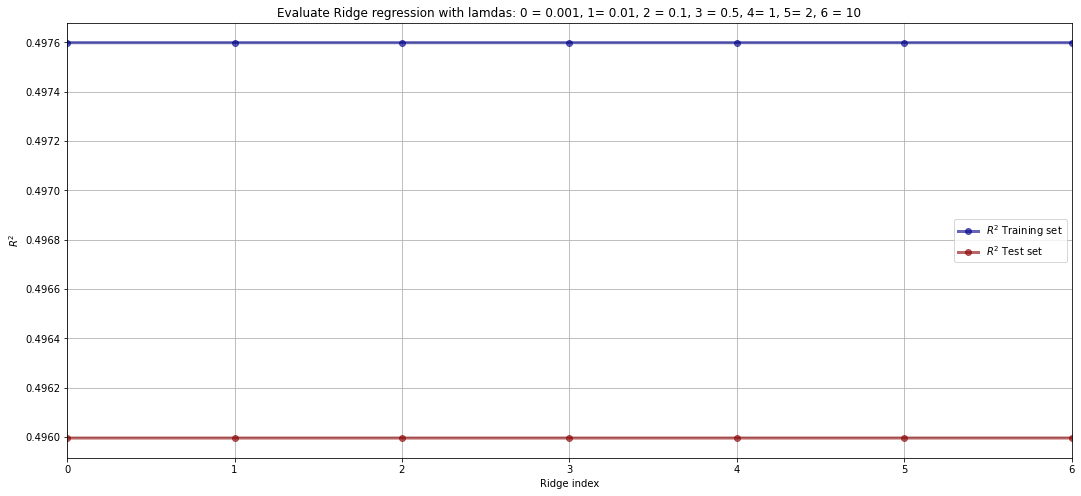

In [93]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Ridge(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Ridge index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate Ridge regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()